# Playing with Generative AI

This is a toy project using generative AI to study drug discovery. 

## General Notes

Idea: Train a generative model (such as a variational autoencoder or diffusion model) to design (new) bioactive molecules,
in particular kinase inhibitors[^1] for cancer therapy. 

I plan to use knowledge from my studies in quantum chemistry and computer science, using features like the HOMO-LUMO gap,
partial charges, and electronic excitations into the model, as well as physical constraints to ensure realistic molecules

[^1]: TODO: I will want to write more general notes one kinase inhibitors later.

### To start 

0. Set up directory structure, with src/ tests/ notebooks/ experiments/
1. Explore QM9 dataset, make sure you can visualise molecules
   1. Make sure to visualize both molecular graphs and properties (like HOMO-LUMO gap, molecular weight, etc.) to get a sense of the data distribution
   2. It might also help to visualize the correlation between different properties to identify which targets might be more informative
2. Train a simple GraphVAE on the QM9 dataset
   1. Perhaps only use a subset of the targets -- not sure which but targeting the atomisation energy at 0 K as well as room temperature probably doesn't make sense
      1. HOMO-LUMO gap, dipole moment, molecular weight
      2. Verifying the VAE’s reconstruction quality on both molecular graph and properties to ensure the model learns meaningful representations
3. Verify that you can generate random molecules by sampling the latent space randomly
   1. Ensure that the molecules look realistic and consistent with the distribution in QM9
4. Use a simple reinforcement learning algorithm to search for the molecule that has the smallest HOMO-LUMO gap
   1. Note: this will require calculating properties e.g. with PySCF for every new molecule to feed back into the model
   2. A smaller HOMO-LUMO gap indicates high reactivity
   3. This is not a realistic target in drug discovery, but it is a reasonable surrogate for a simple "toy problem" such as this
5. Once that is done...

### Next steps

6. Modify the model to enforce realistic physics, i.e. that the models we generate are actually stable
   1. I'm not really sure what this will mean in practice, but I do not want to generate molecules that cannot exist anyway
   2. Introduce constraints during the molecule generation process (e.g., valid bond lengths, bond angles)
   3. Use molecular force fields
   4. Experiment with deep GNNs instead of VAEs (primarily using VAEs since I already have experience, albeit for a different type of problem)
7. Augment dataset to include biologically-relevant properties, e.g. from ZINC
   1. This will allow you to target e.g. binding free energy, binding affinities, low toxicity, logP ...
8. Use heuristics and methods from drug discovery (such as Lipinski's rule of five) to verify generated molecules
   1. QED (Quantitative Estimate of Drug-likeness) or ADMET (absorption, distribution, metabolism, excretion, toxicity)

### Project Structure
Might look something like this 

```
generative-molecular-design/
├── data/
│   ├── raw/                  # Raw datasets (e.g., QM9, ZINC, etc.)
│   ├── processed/            # Preprocessed and cleaned data (e.g., graphs, properties, etc.)
│   └── augmented/            # Augmented data (e.g., biologically-relevant data from ZINC)
├── notebooks/                # Jupyter notebooks for exploration and analysis
|   ├── 00_plan.ipynb         # This Jupyter notebook
│   ├── 01_explore_qm9.ipynb  # Explore QM9 dataset and visualize molecules
│   ├── 02_train_graphvae.ipynb  # Train GraphVAE on QM9 dataset
│   └── 03_rl_homo_gap_search.ipynb  # Reinforcement learning for searching HOMO-LUMO gap
├── src/                      # Main source code for the project
│   ├── __init__.py           # Make it a Python package
│   ├── data_preprocessing.py # Preprocessing functions for datasets
│   ├── graphvae.py           # GraphVAE model definition
│   ├── reinforcement_learning.py # Reinforcement learning module
│   ├── pyscf_utils.py        # Interface with PySCF for quantum chemistry calculations
│   ├── molecule_generation.py # Functions for generating and evaluating molecules
│   └── utils.py              # General utility functions (e.g., visualization, data saving)
├── tests/                    # Unit tests for the code
│   ├── test_graphvae.py       # Tests for GraphVAE functionality
│   ├── test_rl.py            # Tests for reinforcement learning algorithm
│   ├── test_molecule_generation.py  # Tests for molecule generation and validation
│   └── test_pyscf_utils.py   # Tests for PySCF integration
├── docs/                     # Documentation folder
│   ├── index.rst             # Main entry point for the documentation
│   ├── requirements.txt      # List of dependencies
│   ├── README.md             # Project overview, setup, and usage instructions
│   └── api_reference.rst     # If you have an API or specific functions to document
├── experiments/              # Logs, model outputs, and experiment tracking
│   ├── graphvae_model/       # Folder to save trained GraphVAE models
│   ├── rl_experiment_01/     # Reinforcement learning logs and data
│   └── molecule_results/     # Folder to store generated molecules and their properties
├── .gitignore                # Files to ignore in version control (e.g., model checkpoints)
└── setup.py                  # For package setup and dependency management
```

## Exploratory Data Analysis

In [2]:
import torch
import torch_geometric as pyg
from torch_geometric.datasets import QM9
from torch_geometric.data import DataLoader

# using the QM9 dataset, as it includes quantum properties and is of modest size
dataset = QM9(root="data/QM9")

In [3]:
import rdkit
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
def moltosvg(mol,molSize=(450,150),kekulize=True):
    # taken from
    # https://rdkit.blogspot.com/2015/02/new-drawing-code.html
    mc = rdkit.Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            rdkit.Chem.Kekulize(mc)
        except:
            mc = rdkit.Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return svg.replace('svg:','')

from rdkit import Chem

# pyg.utils.to_rdmol(dataset[100])

# # Convert the first molecule in the dataset to an RDKit molecule
# rdkit_mol = pyg.utils.to_rdmol(dataset[0])

# # Convert the RDKit molecule to a SMILES string
# smiles = Chem.MolToSmiles(rdkit_mol)
# # Convert the first molecule in the dataset to an RDKit molecule
# rdkit_mol = pyg.utils.from_smiles(Chem.MolToSmiles(dataset[0]))

# # Convert the RDKit molecule to a SMILES string
# smiles = Chem.MolToSmiles(rdkit_mol)
# print(smiles)


In [4]:
type(dataset[0])

torch_geometric.data.data.Data

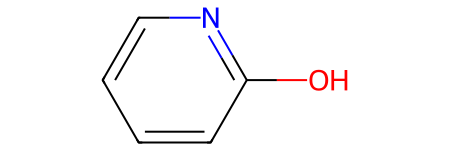

In [5]:
from IPython.display import SVG

m = Chem.MolFromSmiles('c1cccnc1O')
SVG(moltosvg(m))


In [ ]:
# Visualisation helper functions taken from
# https://colab.research.google.com/github/chaitjo/geometric-gnn-dojo/blob/main/geometric_gnn_101.ipynb#scrollTo=ExJ0b3xcQl5n
import py3Dmol
from rdkit.Chem import AllChem
import rdkit.Chem as Chem
from rdkit.Chem import QED, Crippen, rdMolDescriptors, rdmolops
from rdkit.Geometry.rdGeometry import Point3D

allowable_atoms = [
    "H",
    "C",
    "N",
    "O",
    "F",
    "C",
    "Cl",
    "Br",
    "I",
    "H",
    "Unknown",
]

def to_atom(t):
    try:
        return allowable_atoms[int(t.argmax())]
    except:
        return "C"


def to_bond_index(t):
    t_s = t.squeeze()
    return [1, 2, 3, 4][
        int(
            torch.dot(
                t_s,
                torch.tensor(
                    range(t_s.size()[0]), dtype=torch.float, device=t.device
                ),
            ).item()
        )
    ]

def to_rdkit(data, device=None):
    has_pos = False
    node_list = []
    for i in range(data.x.size()[0]):
        node_list.append(to_atom(data.x[i][:5]))

    # create empty editable mol object
    mol = Chem.RWMol()
    # add atoms to mol and keep track of index
    node_to_idx = {}
    invalid_idx = set([])
    for i in range(len(node_list)):
        if node_list[i] == "Stop" or node_list[i] == "H":
            invalid_idx.add(i)
            continue
        a = Chem.Atom(node_list[i])
        molIdx = mol.AddAtom(a)
        node_to_idx[i] = molIdx

    added_bonds = set([])
    for i in range(0, data.edge_index.size()[1]):
        ix = data.edge_index[0][i].item()
        iy = data.edge_index[1][i].item()
        bond = to_bond_index(data.edge_attr[i])  # <font color='red'>TODO</font> fix this
        # bond = 1
        # add bonds between adjacent atoms

        if data.edge_attr[i].sum() == 0:
          continue

        if (
            (str((ix, iy)) in added_bonds)
            or (str((iy, ix)) in added_bonds)
            or (iy in invalid_idx or ix in invalid_idx)
        ):
            continue
        # add relevant bond type (there are many more of these)

        if bond == 0:
            continue
        elif bond == 1:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 2:
            bond_type = Chem.rdchem.BondType.DOUBLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 3:
            bond_type = Chem.rdchem.BondType.TRIPLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 4:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)

        added_bonds.add(str((ix, iy)))

    if has_pos:
        conf = Chem.Conformer(mol.GetNumAtoms())
        for i in range(data.pos.size(0)):
            if i in invalid_idx:
                continue
            p = Point3D(
                data.pos[i][0].item(),
                data.pos[i][1].item(),
                data.pos[i][2].item(),
            )
            conf.SetAtomPosition(node_to_idx[i], p)
        conf.SetId(0)
        mol.AddConformer(conf)

    # Convert RWMol to Mol object
    mol = mol.GetMol()
    mol_frags = rdmolops.GetMolFrags(mol, asMols=True, sanitizeFrags=False)
    largest_mol = max(mol_frags, default=mol, key=lambda m: m.GetNumAtoms())
    return largest_mol


def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D

    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')

    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

def smi2conf(smiles):
    '''Convert SMILES to rdkit.Mol with 3D coordinates'''
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
        return mol
    else:
        return None

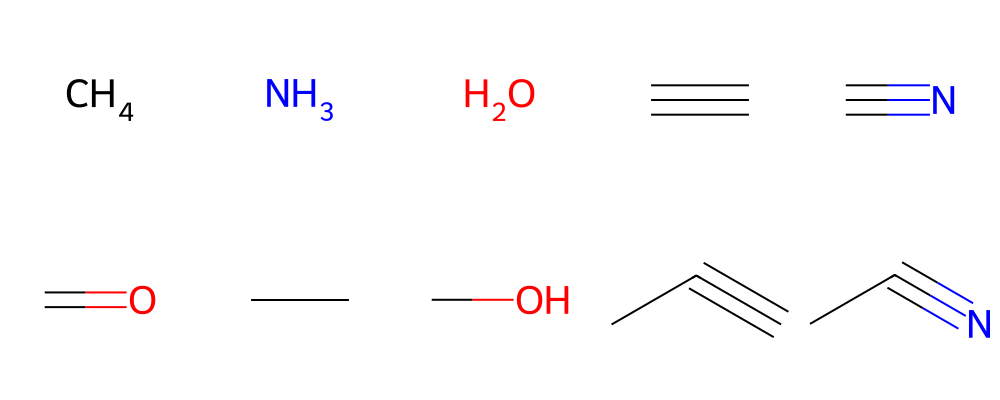

In [7]:
num_viz = 10
mols = [to_rdkit(dataset[i]) for i in range(num_viz)]
Chem.Draw.MolsToGridImage(mols, molsPerRow=5)

In [8]:
visualise_molecule = lambda x: MolTo3DView(smi2conf(Chem.MolToSmiles(to_rdkit(x))))

In [12]:
test_mol = dataset[0]
visualise_molecule(test_mol)
tmp = smi2conf(Chem.MolToSmiles(to_rdkit(test_mol)))
# moltosvg(Chem.MolToSmiles(to_rdkit(test_mol)))
# SVG(moltosvg(Chem.MolToSmiles(to_rdkit(test_mol))))

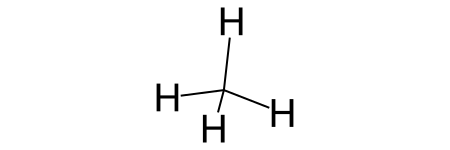

In [14]:
SVG(moltosvg(tmp))